In [101]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import Tuple
from sklearn.preprocessing import StandardScaler

In [102]:
sys.path.append("../")
from functions.spike_preprocessing import spike_band_filtering
from functions.spike_detection import detect_spikes, merge_spike_indices, get_waveforms
from functions.feature_extraction import pca_feature_extraction, plot_pca_features, tsne_feature_extraction, plot_tsne_features, umap_feature_extraction

In [103]:
SAMPLE_RATE = 30000     # sampling rate of the signal in Hz
DT = 1 / SAMPLE_RATE
T = 100000
gain = .5  
PRIMARY_COLOUR = "black"
TIME = np.arange(0, T) * DT
THRESHOLD_FACTOR = -5  # set a threshold mulitplier -> heuristic
RANDOM_STATE = 1729

In [104]:
df = pd.read_csv('../../tubingen_exersizes/data/nda_ex_1.csv', header=0, names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))  

channels = df.columns.to_list()
raw_data = df[channels].values

In [105]:
TOTAL_TIME = np.arange(0, len(raw_data[:, 0])) * DT

## Preprocessing

Filter the data using the custom function

In [106]:
# loop through each of the channels and filter them
data = np.empty_like(raw_data)
for i in range(data.shape[1]):
    data[:, i] = spike_band_filtering(y=raw_data[:, i], sample_rate=SAMPLE_RATE, low=500, high=4000)

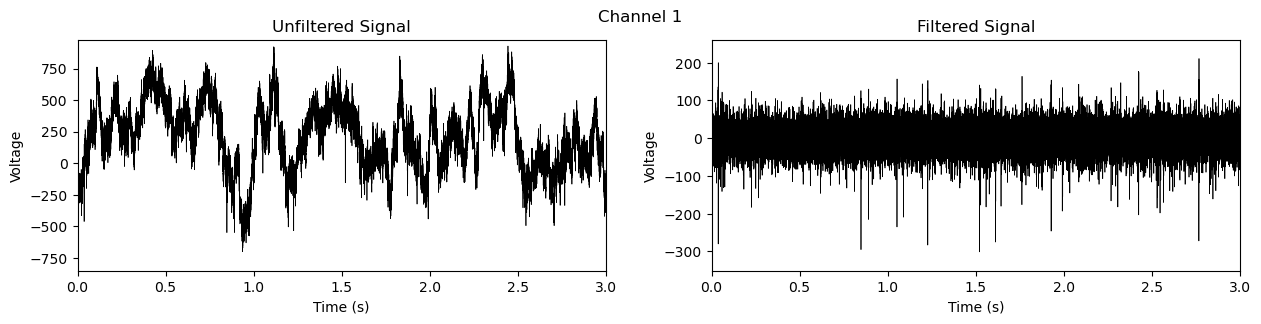

In [107]:
plt.figure(figsize=(15, 3))

# unfiltered signal plot
plt.subplot(1, 2, 1) 
plt.plot(TIME, raw_data[0:T, 1], linewidth=.5, c="k")
plt.ylim((min(raw_data[0:T, 1]) - 50, max(raw_data[0:T, 1]) + 50))
plt.xlim((0, 3))
plt.ylabel('Voltage')
plt.title('Unfiltered Signal')
plt.xlabel("Time (s)")

# filtered signal plot
plt.subplot(1, 2, 2) 
plt.plot(TIME, data[0:T, 1], linewidth=.5, c="k")
plt.ylim((min(data[0:T, 1]) - 50, max(data[0:T, 1]) + 50))
plt.xlim((0, 3))
plt.ylabel('Voltage')
plt.title('Filtered Signal')
plt.xlabel("Time (s)")

plt.suptitle("Channel 1")
plt.show()

## Spike Detection

In [108]:
# initialize spikes as an empty list
spikes = []

# loop through each of the channels
for i in range(data.shape[1]):

    # calculate robust s.d. using the mean absolute deviation (MAD)
    sigma = np.median(np.abs(data[:, i] - np.median(data[:, i])) / 0.6745)

    # set the threshold for this channel
    threshold = THRESHOLD_FACTOR * sigma

    # detect spikes in this channel
    spikes_channel = detect_spikes(y=data[:, i], threshold=threshold, minimum_gap=1, use_absolute_threshold=True, flipped=True)

    # append the detected spikes to the list
    spikes.append(spikes_channel)

# convert spikes to a numpy array
spikes = np.array(spikes)

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_9244/1804144141.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikes = np.array(spikes)


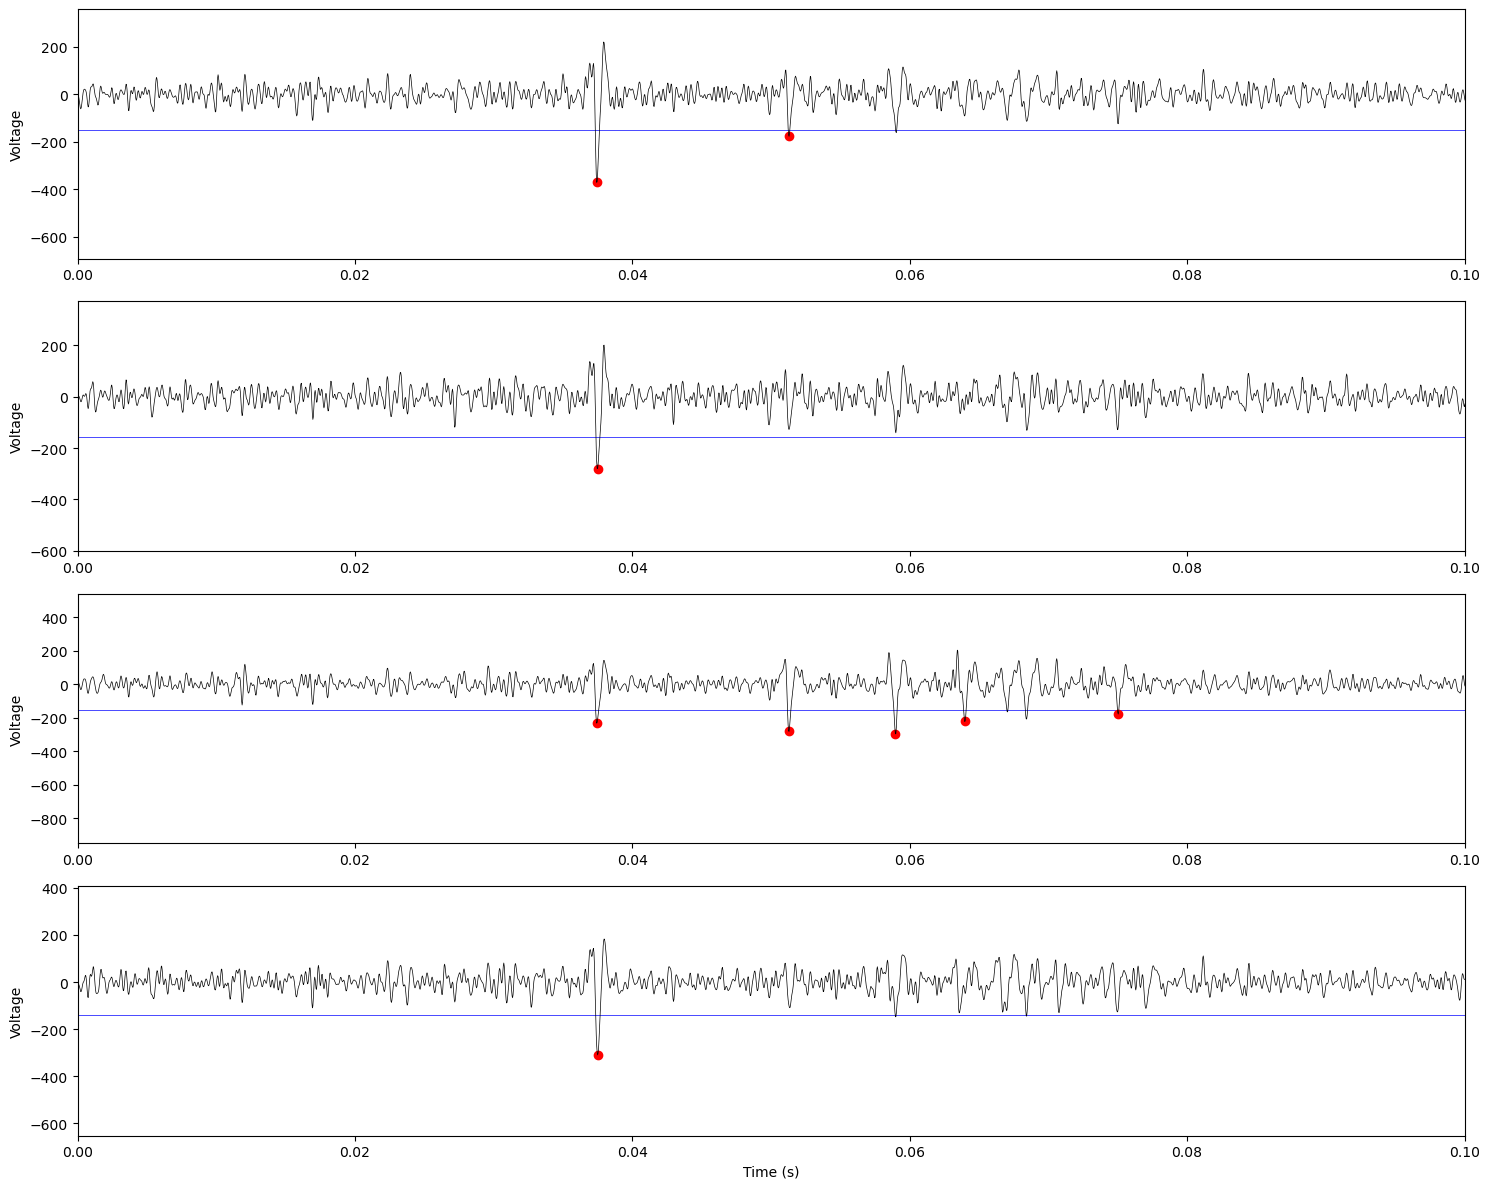

In [109]:
plt.figure(figsize=(15, 3 * data.shape[1]))

for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(TIME[0:T], data[0:T, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data[0:T, i] - np.median(data[:, i])) / 0.6745)
    threshold = THRESHOLD_FACTOR * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(spikes[i] * DT, data[spikes[i], i], color='red')
    
    plt.ylim((min(data[:, i]) - 50, max(data[:, i]) + 50))
    plt.xlim(0, 0.1)
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [110]:
merged_spike_indices = merge_spike_indices(spikes, tolerance=2)

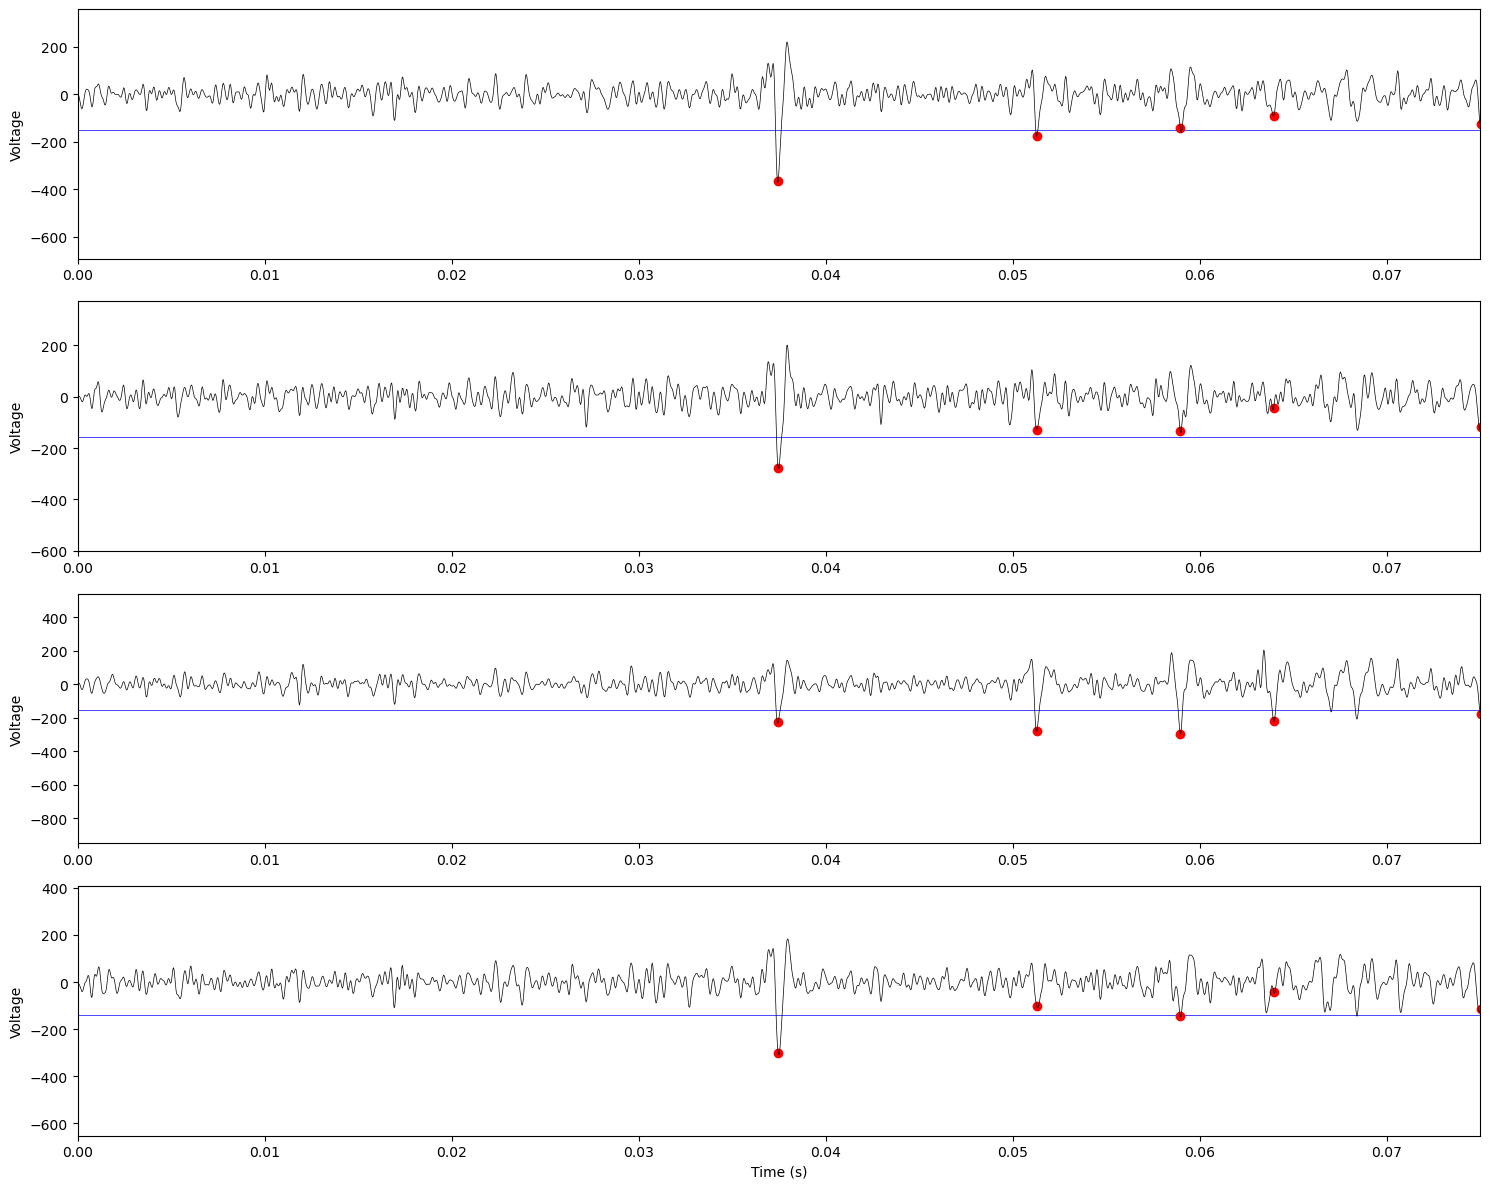

In [111]:
plt.figure(figsize=(15, 3 * data.shape[1]))

for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(TIME[0:T], data[0:T, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data[0:T, i] - np.median(data[:, i])) / 0.6745)
    threshold = THRESHOLD_FACTOR * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(merged_spike_indices * DT, data[merged_spike_indices, i], color='red')
    
    plt.ylim((min(data[:, i]) - 50, max(data[:, i]) + 50))
    plt.xlim(0, 0.075)
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

## Extract Waveforms

In [112]:
waveforms = []
waveform_info = []

# loop through each of the channels
for i in range(data.shape[1]):
    # get waveforms for this channel
    waveforms_channel, waveform_info_channel = get_waveforms(y=data[:, i], spike_indices=merged_spike_indices, duration=1, sample_rate=SAMPLE_RATE, window_shift_ratio=1/3)
    
    # append the waveforms and waveform_info to the lists
    waveforms.append(waveforms_channel)
    waveform_info.append(waveform_info_channel)

# convert waveforms and waveform_info to numpy arrays
waveforms = np.array(waveforms)
waveform_info = np.array(waveform_info)

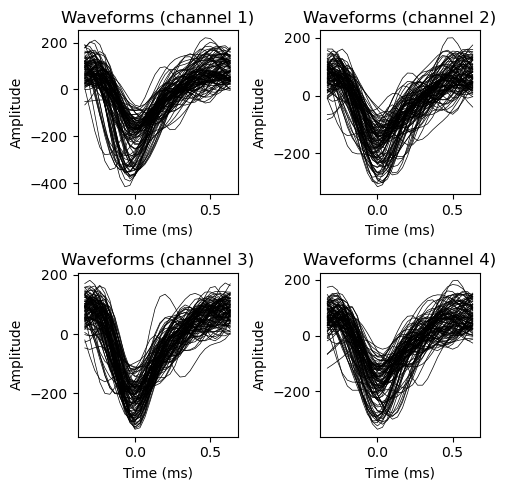

In [113]:
# determine the number of channels
n_channels = waveforms.shape[0]

# calculate the size of the grid
grid_size = int(np.sqrt(n_channels))

# create a figure and subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(grid_size):
    for j in range(grid_size):
        channel_idx = i * grid_size + j
        # iterate over the waveforms in this channel and plot each on top of each other
        for waveform in waveforms[channel_idx][:100]:
            t = np.arange(-10, 20) * DT * 1000 

            # plot the waveform
            axs[i, j].plot(t, waveform, c="black", lw=.5)

        axs[i, j].set_xlabel('Time (ms)')
        axs[i, j].set_ylabel('Amplitude')
        axs[i, j].set_title(f'Waveforms (channel {channel_idx+1})')

plt.tight_layout()
plt.show()

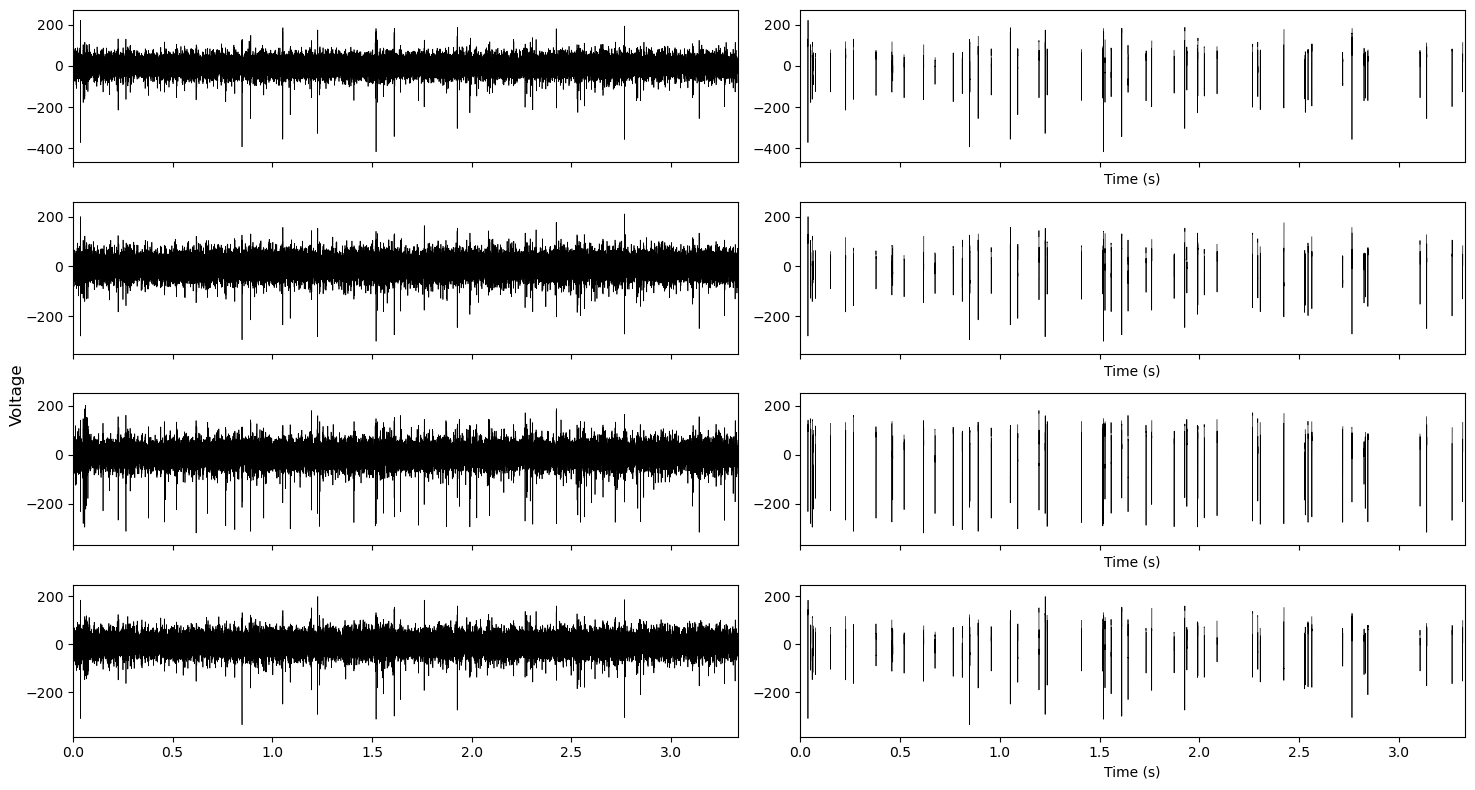

In [114]:
# determine the number of channels
n_channels = data.shape[1]

# create a figure and subplots
fig, axs = plt.subplots(n_channels, 2, figsize=(15, 2 * n_channels), sharex=True)

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(n_channels):

    # plot the raw data for this channel
    axs[i, 0].plot(TIME[0:T], data[:T, i], label='Raw Data', c='k', lw=0.5)
    axs[i, 0].set_ylim((min(data[:T, i]) - 50, max(data[:T, i]) + 50))
    axs[i, 0].set_xlim((0, max(TIME)))
    
    # iterate through each spike and plot its waveform for this channel
    for spike in waveform_info[i]:
        spike_window = slice(spike["spike_start"], spike["spike_end"])
        axs[i, 1].plot(TIME[0:T][spike_window], data[:T, i][spike_window], c='k', lw=0.5)

    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylim((min(data[:T, i]) - 50, max(data[:T, i]) + 50))
    axs[i, 1].set_xlim((0, max(TIME[0:T])))

fig.supylabel("Voltage")
plt.tight_layout()
plt.show()

## Feature Extraction

In [115]:
n_components = 3

b = []
explained_variance_ratios = []
for i in range(waveforms.shape[0]):
    waveform = waveforms[i]

    # initialise PCA
    pca = PCA(n_components=n_components)

    b.append(pca.fit_transform(waveform))

    explained_variance_ratios.append(pca.explained_variance_ratio_)

In [116]:
print("Explained Variance Ratios:", explained_variance_ratios)

Explained Variance Ratios: [array([0.49698376, 0.26245482, 0.07091969]), array([0.41494577, 0.25445274, 0.10346883]), array([0.45564023, 0.25381247, 0.08925478]), array([0.43440472, 0.24913857, 0.1007529 ])]


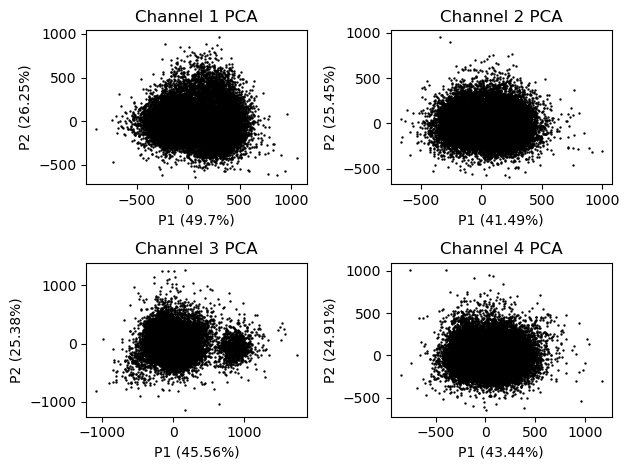

In [117]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]
    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=.5, c=PRIMARY_COLOUR)

plt.tight_layout()
plt.show()

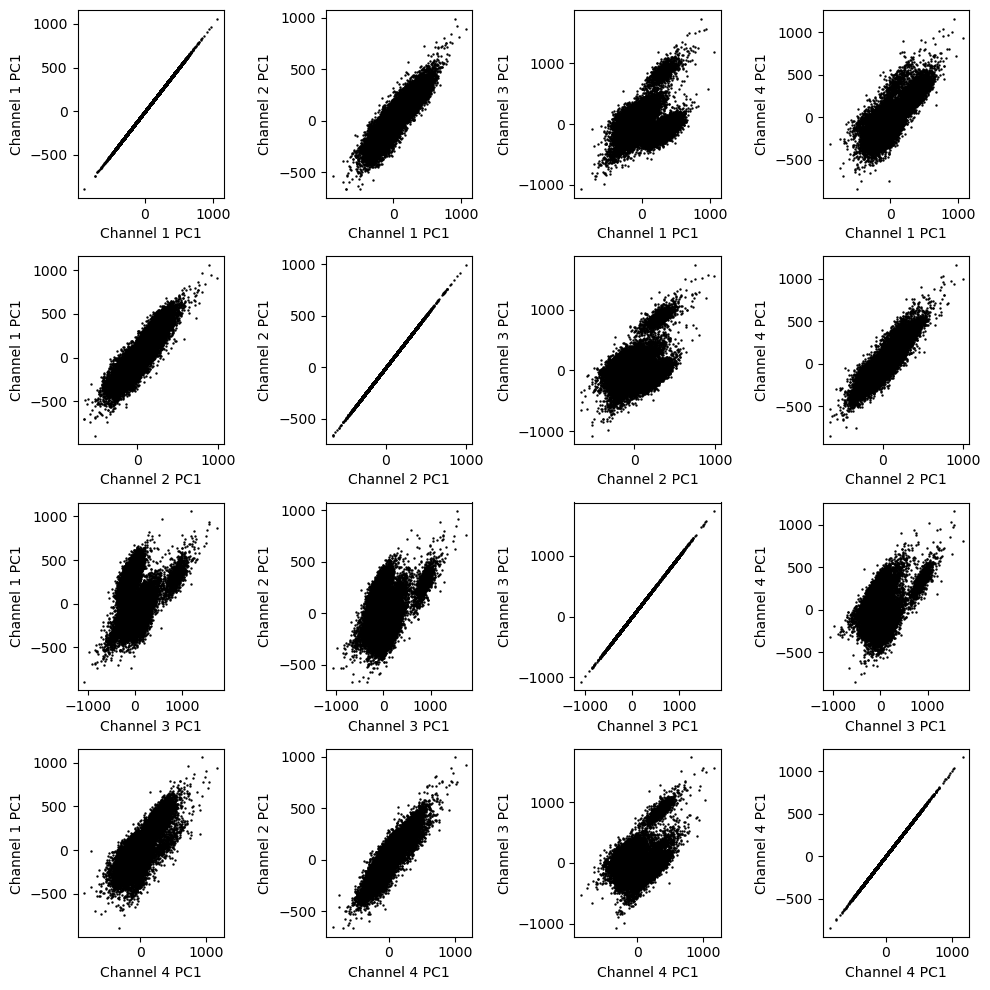

In [118]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(10, 10))

# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):
        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(b[i][:, 0], b[j][:, 0], c=PRIMARY_COLOUR, s=.5)
        axs[i, j].set_xlabel(f"Channel {i + 1} PC1")
        axs[i, j].set_ylabel(f"Channel {j + 1} PC1")

plt.tight_layout()
plt.show()

## Clustering

In [119]:
from sklearn.mixture import GaussianMixture 

def mog(x: np.ndarray, k: int) -> Tuple[np.ndarray]:
    """
    Fit Mixture of Gaussian model
    ind, m, S, p = mog(x, k) fits a Mixture of Gaussian model to the data
    in x using k components. The output ind contains the MAP assignments of the
    datapoints in x to the found clusters. The outputs m, S, p contain
    the model parameters.

    Parameters
    ----------
    x: np.array 
        The datapoints -> N (Number of datapoints) x D (dimensionality of the data)
    k: int
        Number of clusters

    Returns
    ----------
    ind: np.array 
        Cluster indicators
    m: np.array
        Cluster means    (k x D)
    S: np.array 
        Cluster covarience matricies    (D x D x k)
    p: np.array 
        Cluster prior probabilities    (k x 1)
    """
    
    # fit the model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(x)

    # get the MAP assignments of the data points
    ind = gmm.predict(x)

    # get the model parameters
    m = gmm.means_
    S = gmm.covariances_
    p = gmm.weights_


    return (ind, m, S, p)

from scipy.stats import multivariate_normal

def compute_log_likelihood(x, m, S, p):
    """
    Compute the log-likelihood of the data under the model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k by 1

    Returns:
        LL (float): Log-likelihood
    """
    k = m.shape[0]
    n = x.shape[0]
    LL = 0
    for i in range(n):
        temp = 0
        for j in range(k):
            temp += p[j] * multivariate_normal(m[j], S[j]).pdf(x[i])
        LL += np.log(temp)
    return LL

def mog_bic(x, m, S, p):
    """
    Compute the BIC for a fitted Mixture of Gaussian model
    bic, LL = mog_bic(x,k) computes the the Bayesian Information 
    Criterion value and the log-likelihood of the fitted model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k

    Returns:
        bic (float): BIC
        LL (float): Log-likelihood
    """
    n, d = x.shape
    k = m.shape[0]

    # Compute the log-likelihood
    LL = compute_log_likelihood(x, m, S, p)

    # Compute the number of parameters
    P = k * (d + (d * (d + 1) / 2) + 1)

    # Compute the BIC
    bic = -2 * LL + P * np.log(n)
    
    return bic, LL

In [120]:
x = np.array(b)
x = np.transpose(x, (1, 0, 2)).reshape((-1, x.shape[0] * x.shape[2]))
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [121]:
# K = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# BIC = np.zeros((len(K)))
# LL = np.zeros((len(K)))

# # loop over the number of clusters
# for i, k in enumerate(K):
#     # fit the GMM to the data
#     ind, m, S, p = mog(x, k)

#     # compute the BIC and log-likelihood
#     bic, ll = mog_bic(x, m, S, p)

#     # store the results
#     BIC[i] = bic
#     LL[i] = ll

# print("BIC: \n", BIC)
# print("Log-likelihood: \n", LL)

In [122]:
# number of clusters that gives the lowest BIC
# optimal_k = K[np.argmin(BIC)]
optimal_k = 12

# Refit the model with the optimal number of clusters
ind, m, S, p = mog(x, optimal_k)

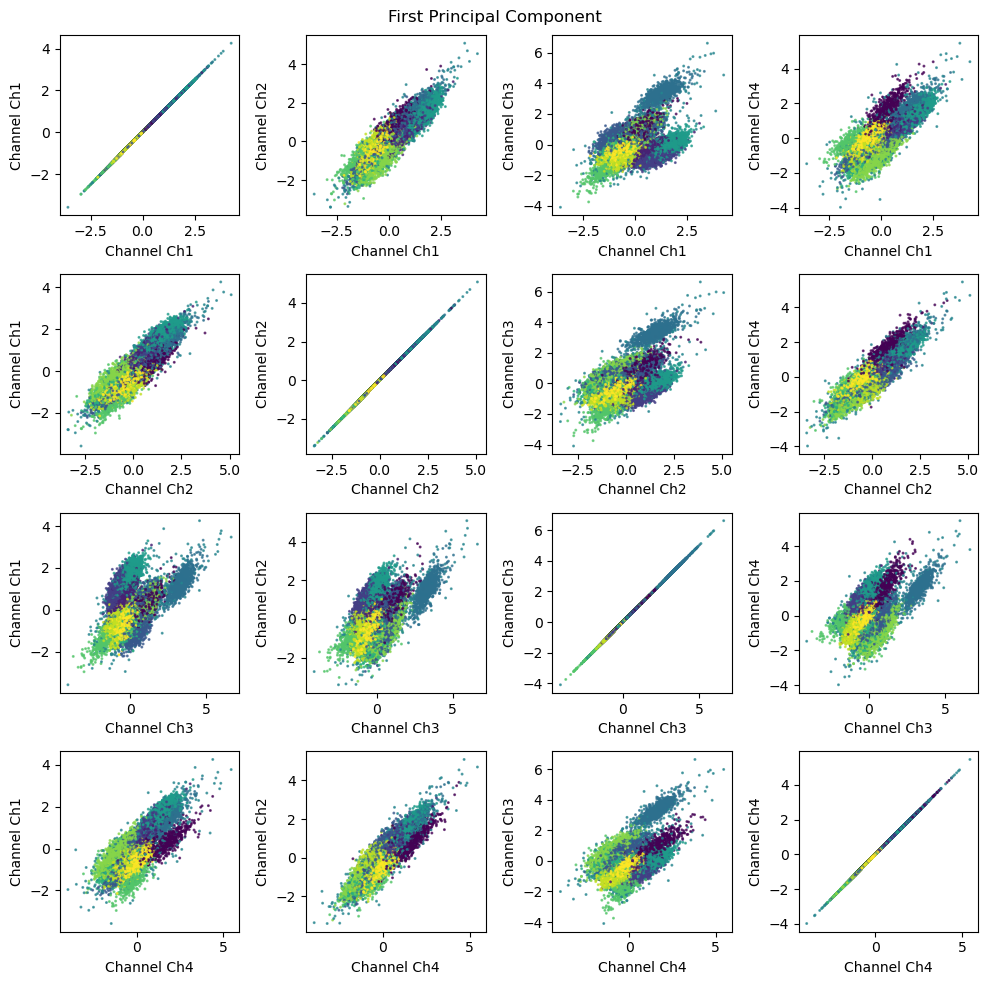

In [124]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(10, 10))

idx = [0, 3, 6, 9]
# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):
        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(x[:,idx[i]], x[:,idx[j]], c=ind, cmap='viridis', s=5, marker='.', alpha=0.7) 
        axs[i, j].set_xlabel(f"Channel {channels[i]}")
        axs[i, j].set_ylabel(f"Channel {channels[j]}")

plt.suptitle("First Principal Component")
plt.tight_layout()
plt.show()

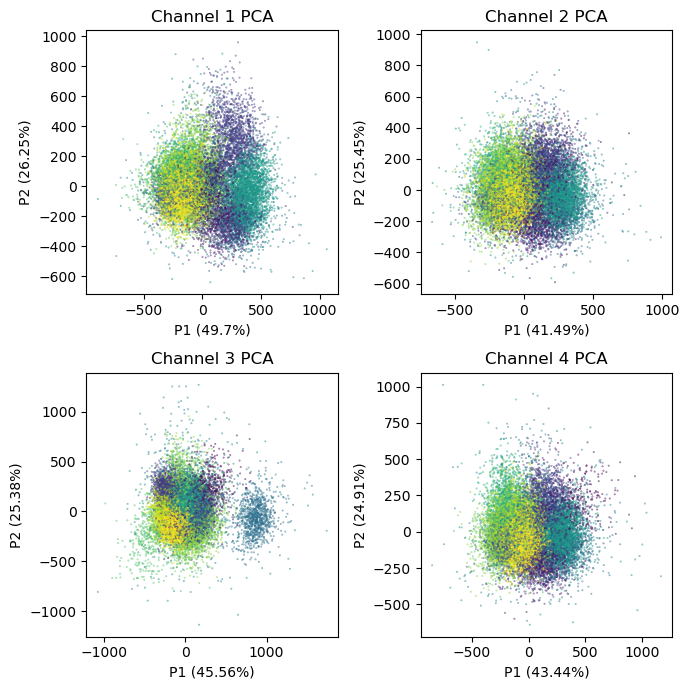

In [125]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 7))

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]
    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=.5, c=ind, cmap='viridis', marker='.', alpha=0.7) 

plt.tight_layout()
plt.show()